In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

pd.pandas.set_option('display.max_columns', None)

In [14]:
df = pd.read_csv('../data/sample.csv')
df.head()
print(df.shape)

(29236, 17)


In [16]:
def add_id(df):
    df = df.copy()
    df['id'] = df.index + 1
    
    return df

df = add_id(df)
print(df.shape)
df.head()

(29236, 18)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,id
0,2,2017-03-06 12:10,2017-03-06 12:20,2,2.03,1,N,140,236,1,9.0,0.0,0.5,1.96,0.0,0.3,11.76,1
1,1,2017-06-14 8:11,2017-06-14 8:14,1,0.40,1,N,43,142,1,4.5,0.0,0.5,1.05,0.0,0.3,6.35,2
2,2,2017-11-22 19:42,2017-11-22 19:49,3,1.04,1,N,151,238,1,6.5,1.0,0.5,0.00,0.0,0.3,8.30,3
3,2,2017-11-12 16:58,2017-11-12 17:09,1,1.79,1,N,239,236,2,9.5,0.0,0.5,0.00,0.0,0.3,10.30,4
4,1,2017-06-14 22:01,2017-06-14 22:06,1,1.20,1,N,246,246,1,6.0,0.5,0.5,2.15,0.0,0.3,9.45,5


In [19]:
def remove_invalid_neg(df, cols):
    """
    Remove negative values columns where it is not possible to have negative values
    """
    for col in cols:
        df = df[df[col] >= 0]
    
    return df

neg_cols = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']
df = remove_invalid_neg(df, neg_cols)
print(df.shape)

(29208, 18)


In [20]:
def remove_invalid_zeroes(df, cols):
    """
    Remove zero values from where it is not possible to have zero values
    """
    for col in cols:
        df = df[df[col] > 0]
    
    return df

zero_cols = ['fare_amount', 'total_amount']
df = remove_invalid_zeroes(df, zero_cols)
print(df.shape)

(29208, 18)


In [22]:
def remove_error_RatecodeID(df):
    """
    Remove the one erroenous coding instance 
    """
    
    df = df[df.RatecodeID != 99]
    
    return df

df = remove_error_RatecodeID(df)

In [23]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,id
count,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000
mean,1.541309,1.630157,2.948309,1.042113,162.780909,161.145376,1.326326,20.613453,0.332232,0.497809,1.886482,0.336510,0.299969,23.970168,14619.143151
std,0.498299,1.270682,3.799932,0.294800,66.426698,70.243998,0.487704,1277.422133,0.446744,0.033028,2.658190,1.501481,0.003040,1277.434953,8441.029991
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310000,1.000000
25%,1.000000,1.000000,0.980000,1.000000,114.000000,112.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000,7308.500000
50%,2.000000,1.000000,1.600000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.400000,0.000000,0.300000,11.800000,14619.000000
75%,2.000000,2.000000,3.020000,1.000000,233.000000,233.000000,2.000000,15.000000,0.500000,0.500000,2.460000,0.000000,0.300000,17.850000,21929.500000
max,2.000000,6.000000,72.680000,5.000000,265.000000,265.000000,4.000000,218316.300000,4.500000,0.500000,100.300000,25.000000,0.300000,218317.090000,29236.000000


In [56]:
# train, test split
# set seed for reproducibility 

X_train, X_test, y_train, y_test = train_test_split(df, df.tip_amount,
                                                    test_size=0.1,
                                                    random_state=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26286, 18), (2921, 18), (26286,), (2921,))

### Time variable

In [57]:
def trip_time(df, start, end):
    """
    start: pickup time
    end: dropoff time
    
    Extracts time information from the two variables. 
    """
    df = df.copy()
    
    df['pickup'] = pd.to_datetime(df[start])
    df['dropoff'] = pd.to_datetime(df[end])
    
    df['trip_time'] = df['dropoff'] - df['pickup']
    
    # convert to minutes
    df['trip_seconds'] = df['trip_time'].astype('timedelta64[s]')
        
    df = df.drop(columns=[start, end, 'trip_time', 'pickup', 'dropoff'])
    
    return df

In [58]:
X_train = trip_time(X_train, 'tpep_pickup_datetime', 'tpep_dropoff_datetime')
X_test = trip_time(X_test, 'tpep_pickup_datetime', 'tpep_dropoff_datetime')

In [59]:
X_train.shape

(26286, 17)

### Numerical variables
- Log transform those without zeros to get a more Gaussian distribution to help linear machine learning models

In [60]:
# log transform numeric variables that do not contain zeros
for var in ['fare_amount', 'total_amount']:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])

### Categorical variables
- convert strings to numbers to capture monotonic relationship between label and target

In [61]:
# for one hot encoding
# a few variables have been coded as an int instead of a categorical variable
var_to_str = ['RatecodeID', 'store_and_fwd_flag', 'payment_type']

def to_str(train, test, var):
    train[var] = train[var].astype(str)
    test[var] = test[var].astype(str)
    
for var in var_to_str:
    to_str(X_train, X_test, var)

In [62]:
# check cardinality of non-numeric features we want to one-hot encode
X_train.describe(include='O').T.sort_values(by='unique')

,count,unique,top,freq
store_and_fwd_flag,26286,2,N,26144
payment_type,26286,4,1,17914
RatecodeID,26286,5,1,25512


In [63]:
X_train.RatecodeID.value_counts(normalize=False)

1    25512
2      612
5       88
3       60
4       14
Name: RatecodeID, dtype: int64

In [64]:
X_train.payment_type.value_counts(normalize=False)

1    17914
2     8212
3      117
4       43
Name: payment_type, dtype: int64

In [65]:
# need to reduce cardinality of PULocationID & DOLocationID
X_train.PULocationID.value_counts().sum

# get list of top 10 locations
top10PU = X_train['PULocationID'].value_counts()[:10].index
top10DO = X_train['DOLocationID'].value_counts()[:10].index

# for locationIDs not in the top 10, replace with OTHER
X_train.loc[~X_train['PULocationID'].isin(top10PU), 'PULocationID'] = 'OTHER'
X_train.loc[~X_train['DOLocationID'].isin(top10DO), 'DOLocationID'] = 'OTHER'

X_test.loc[~X_test['PULocationID'].isin(top10PU), 'PULocationID'] = 'OTHER'
X_test.loc[~X_test['DOLocationID'].isin(top10DO), 'DOLocationID'] = 'OTHER'

In [66]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)

X_train['RatecodeID'] = X_train['RatecodeID'].replace({'1': 'one', '2': 'two', '3': 'three', '4': 'four', '5': 'five', '6': 'six'})
X_test['RatecodeID'] = X_test['RatecodeID'].replace({'1': 'one', '2': 'two', '3': 'three', '4': 'four', '5': 'five', '6': 'six'})

X_train['store_and_fwd_flag'] = X_train['store_and_fwd_flag'].replace({'1': 'one', '2': 'two'})
X_test['store_and_fwd_flag'] = X_test['store_and_fwd_flag'].replace({'1': 'one', '2': 'two'})

X_train['payment_type'] = X_train['payment_type'].replace({'1': 'one', '2': 'two', '3': 'three', '4': 'four'})
X_test['payment_type'] = X_test['payment_type'].replace({'1': 'one', '2': 'two', '3': 'three', '4': 'four'})

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.fit_transform(X_test)

X_train_encoded.head()

,VendorID,passenger_count,trip_distance,RatecodeID_one,RatecodeID_five,RatecodeID_two,RatecodeID_three,RatecodeID_four,store_and_fwd_flag_N,store_and_fwd_flag_Y,PULocationID_OTHER,PULocationID_162,PULocationID_161,PULocationID_236,PULocationID_170,PULocationID_186,PULocationID_230,PULocationID_142,PULocationID_48,PULocationID_234,PULocationID_237,DOLocationID_OTHER,DOLocationID_237,DOLocationID_161,DOLocationID_186,DOLocationID_236,DOLocationID_234,DOLocationID_48,DOLocationID_142,DOLocationID_230,DOLocationID_170,DOLocationID_162,payment_type_one,payment_type_two,payment_type_three,payment_type_four,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,id,trip_seconds
25323,2,1,0.96,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.704748,0.5,0.5,1.36,0.0,0.3,2.099244,25324,300.0
25133,2,2,1.03,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2.251292,0.0,0.5,2.58,0.0,0.3,2.555676,25134,840.0
27634,1,1,8.10,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3.449988,1.0,0.5,3.70,0.0,0.3,3.610918,27635,2340.0
9500,1,1,0.30,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1.386294,0.0,0.5,0.00,0.0,0.3,1.568616,9501,180.0
21992,1,1,3.80,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2.639057,0.5,0.5,3.80,0.0,0.3,2.949688,21993,840.0


In [67]:
X_train_encoded.shape, X_test_encoded.shape

((26286, 45), (2921, 45))

In [68]:
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']
cat_vars

['RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type']

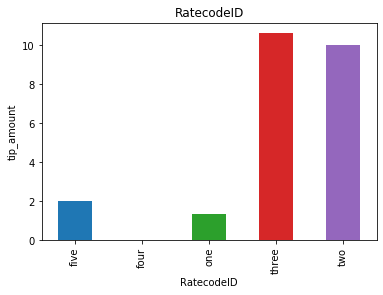

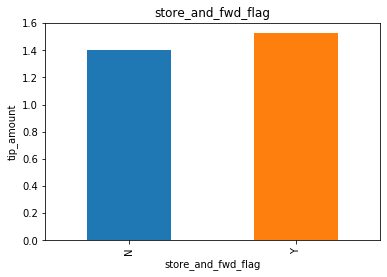

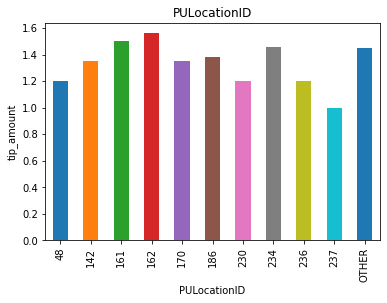

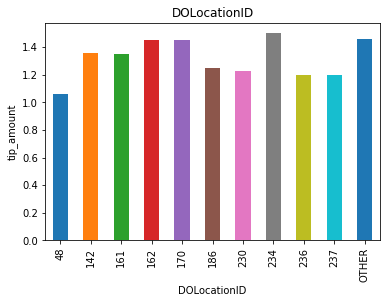

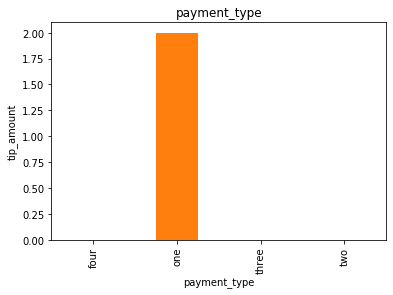

In [69]:
# is there a monotonic relationship between the labels and tip amount?
def analyse_vars(df, var):
    df = df.copy()
    df.groupby(var)['tip_amount'].median().plot.bar()
    plt.title(var)
    plt.ylabel('tip_amount')
    plt.show()
    
for var in cat_vars:
    analyse_vars(X_train, var)

### Feature scaling
- for linear models

In [70]:
features = [var for var in X_train_encoded.columns if var not in ['id', 'tip_amount']]

X_train_encoded[['id', 'tip_amount']].reset_index(drop=True)

,id,tip_amount
0,25324,1.36
1,25134,2.58
2,27635,3.70
3,9501,0.00
4,21993,3.80
5,4850,0.68
6,22731,0.00
7,19055,0.00
8,5033,3.15
9,24773,1.00


In [71]:
scaler = MinMaxScaler()
scaler.fit(X_train_encoded[features])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [72]:
X_train_scaled = pd.concat([X_train_encoded[['id', 'tip_amount']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(X_train_encoded[features]), columns=features)],
                    axis=1)

X_test_scaled = pd.concat([X_test_encoded[['id', 'tip_amount']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(X_test_encoded[features]), columns=features)],
                    axis=1)

In [73]:
X_train_scaled.shape, y_train.shape, X_test_scaled.shape, y_test.shape

((26286, 45), (26286,), (2921, 45), (2921,))

In [74]:
X_train_scaled.head()

,id,tip_amount,VendorID,passenger_count,trip_distance,RatecodeID_one,RatecodeID_five,RatecodeID_two,RatecodeID_three,RatecodeID_four,store_and_fwd_flag_N,store_and_fwd_flag_Y,PULocationID_OTHER,PULocationID_162,PULocationID_161,PULocationID_236,PULocationID_170,PULocationID_186,PULocationID_230,PULocationID_142,PULocationID_48,PULocationID_234,PULocationID_237,DOLocationID_OTHER,DOLocationID_237,DOLocationID_161,DOLocationID_186,DOLocationID_236,DOLocationID_234,DOLocationID_48,DOLocationID_142,DOLocationID_230,DOLocationID_170,DOLocationID_162,payment_type_one,payment_type_two,payment_type_three,payment_type_four,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,trip_seconds
0,25324,1.36,1.0,0.166667,0.013209,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.373393,0.111111,1.0,0.0,1.0,0.242886,0.040803
1,25134,2.58,1.0,0.333333,0.014172,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.405735,0.000000,1.0,0.0,1.0,0.276784,0.046823
2,27635,3.70,0.0,0.166667,0.111447,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.476668,0.222222,1.0,0.0,1.0,0.355153,0.063545
3,9501,0.00,0.0,0.166667,0.004128,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.354548,0.000000,1.0,0.0,1.0,0.203477,0.039465
4,21993,3.80,0.0,0.166667,0.052284,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.428681,0.111111,1.0,0.0,1.0,0.306046,0.046823


In [75]:
X_train_scaled.isnull().sum()

id                       0
tip_amount               0
VendorID                 0
passenger_count          0
trip_distance            0
RatecodeID_one           0
RatecodeID_five          0
RatecodeID_two           0
RatecodeID_three         0
RatecodeID_four          0
store_and_fwd_flag_N     0
store_and_fwd_flag_Y     0
PULocationID_OTHER       0
PULocationID_162         0
PULocationID_161         0
PULocationID_236         0
PULocationID_170         0
PULocationID_186         0
PULocationID_230         0
PULocationID_142         0
PULocationID_48          0
PULocationID_234         0
PULocationID_237         0
DOLocationID_OTHER       0
DOLocationID_237         0
DOLocationID_161         0
DOLocationID_186         0
DOLocationID_236         0
DOLocationID_234         0
DOLocationID_48          0
DOLocationID_142         0
DOLocationID_230         0
DOLocationID_170         0
DOLocationID_162         0
payment_type_one         0
payment_type_two         0
payment_type_three       0
p

In [76]:
X_train_scaled.to_csv('X_train_scaled.csv', index=False)
X_test_scaled.to_csv('X_test_scaled.csv', index=False)